<a href="https://colab.research.google.com/github/pbr142/handson-ml2/blob/master/exercises/VAE_AI_Academy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder for Image Generation

Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples.

In [1]:
from tensorflow import keras

In [2]:
keras.__version__

'2.4.0'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load data

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [5]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [6]:
FINAL = True

In [7]:
if not FINAL:
    n_train = 1000
    n_test = 100
    X_train = X_train[:n_train]
    y_train = y_train[:n_train]
    X_test = X_test[:n_test]
    y_test = y_test[:n_test]

In [8]:
X_train.shape

(50000, 32, 32, 3)

In [9]:
import matplotlib.pyplot as plt

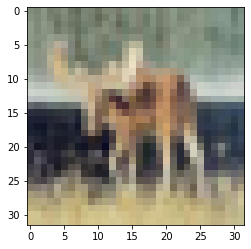

In [10]:
plt.imshow(X_train[28])

## Build VAE

In [11]:
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = K.random_normal(shape=K.shape(z_mean))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
inputs = keras.layers.Input(shape=X_train.shape[1:])
conv1 = keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
conv2 = keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(conv1)
flat = keras.layers.Flatten()(conv2)
dense = keras.layers.Dense(128, activation='relu')(flat)
z_mean = keras.layers.Dense(64)(dense)
z_log_var = keras.layers.Dense(64)(dense)
z = Sampling()([z_mean, z_log_var])
encoder = keras.models.Model(inputs=[inputs], outputs=[z_mean, z_log_var, z], name='encoder')

In [13]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 128)    36992       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 8192)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [14]:
decoder_inputs = keras.layers.Input(shape=[64])
decoder_dense = keras.layers.Dense(128, activation='relu')(decoder_inputs)
decoder_dense2 = keras.layers.Dense(8192, activation='relu')(decoder_dense)
reshape = keras.layers.Reshape(target_shape=[8,8,128])(decoder_dense2)
conv1_t = keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(reshape)
conv2_t = keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same', activation='relu')(conv1_t)
decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[conv2_t])

In [15]:
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 32)        36896     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 3)         867       
Total params: 1,102,851
Trainable params: 1,102,851
Non-trainable params: 0
___________________________________________________

In [16]:
_, _, codings = encoder(inputs)
reconstructions = decoder(codings)
vae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

In [17]:
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 64), (None, 64),  1103104   
_________________________________________________________________
model (Functional)           (None, 32, 32, 3)         1102851   
Total params: 2,205,955
Trainable params: 2,205,955
Non-trainable params: 0
_________________________________________________________________


In [18]:
latent_loss = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)
vae.add_loss(K.mean(latent_loss) / (32*32*3))

In [19]:
vae.compile(loss='binary_crossentropy', optimizer='NAdam', metrics=['mse'])

In [20]:
model_cb = keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Projects/VAE/vae_cifar10_session.ckpt')

In [21]:
history = vae.fit(X_train, X_train, epochs=5, batch_size=256, validation_data=(X_test, X_test), callbacks=[model_cb])

196/196 [==============================] - 41s 48ms/step - loss: 1.5489 - mse: 0.1178 - val_loss: 0.6705 - val_mse: 0.0487
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Projects/VAE/vae_cifar10_session.ckpt/assets
Epoch 2/5
196/196 [==============================] - 9s 44ms/step - loss: 0.6622 - mse: 0.0457 - val_loss: 0.6639 - val_mse: 0.0471
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Projects/VAE/vae_cifar10_session.ckpt/assets
Epoch 3/5
196/196 [==============================] - 8s 43ms/step - loss: 0.6493 - mse: 0.0386 - val_loss: 0.6385 - val_mse: 0.0333
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Projects/VAE/vae_cifar10_session.ckpt/assets
Epoch 4/5
196/196 [==============================] - 9s 43ms/step - loss: 0.6417 - mse: 0.0352 - val_loss: 0.6467 - val_mse: 0.0374
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Projects/VAE/vae_cifar10_session.ckpt/assets
Epoch 5/5
196/196 [==============================] - 8s 43ms/step

In [28]:
y_pred = vae.predict(X_test[0:2])

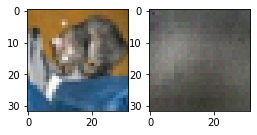

In [29]:
ind = 0
plt.figure(figsize= (4,2))
plt.subplot(1,2, 1)
plt.imshow(X_test[ind])
plt.subplot(1,2,2)
plt.imshow(y_pred[0])